Summary: verify travel times. Judge by comparing the error between grid and reported travel times. (assume I can use 3200 grid?)

In [1]:
import csv
import collections
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

## load all data

In [2]:
# This is the grid object, which is used throughout all data preprocessing.
# It represents the city of Austin through a series of grids.
# It thus makes a tractable way to compute distance between grids, ect. 
class Grid():
    def __init__(self, grid_json):
        self.grid = grid_json
        self.min_lat = self.grid["latitude_min"]
        self.min_lon = self.grid["longitude_min"]
        self.max_lat = self.grid["latitude_max"]
        self.max_lon = self.grid["longitude_max"]
        self.latitude_delta = self.grid["latitude_step"]
        self.longitude_delta = self.grid["longitude_step"]
        self.nrows = math.ceil((self.max_lat - self.min_lat) / self.latitude_delta)
        self.ncols = math.ceil((self.max_lon - self.min_lon) / self.longitude_delta)
        self.times = self.grid["time_matrix"]
        self.census_tract_region_map = self.grid["census_tract_region_mapping"]
        self.region_to_tract = collections.defaultdict(list)
        for census_tract in self.census_tract_region_map:
            for region in self.census_tract_region_map[census_tract]:
                self.region_to_tract[region].append(census_tract)
    def map_point_to_region(self, latitude, longitude):
        return math.floor((latitude-self.min_lat)/self.latitude_delta) * self.ncols  + math.floor((longitude-self.min_lon)/self.longitude_delta)
    def get_representative(self, region_num):
        row_num = region_num//self.ncols
        col_num = region_num - row_num*self.ncols
        lat = self.min_lat + row_num * self.latitude_delta + 0.5*self.latitude_delta
        lon = self.min_lon + col_num * self.longitude_delta + 0.5*self.longitude_delta
        return [lon, lat]
    def get_time(self, region1, region2):
        try:
            return self.times[region1][region2]
        except IndexError:
            return -1
    def region_to_census_tract(self, region):
        try:
            return self.region_to_tract[region]
        except KeyError:
            return "0_0"

In [50]:
#peakHours = (np.genfromtxt("..\Output_Data/peakhours.csv", delimiter=",", dtype = str))
peakHours = (np.genfromtxt("..\Output_Data/austin_data_3200/austin_test_calls_v4.csv", delimiter=",", dtype = str))

with open("..\Input_Data/grid_info_3200_v3.json", "r") as f:
    grid_json = json.load(f)
g = Grid(grid_json)

In [46]:
peakHours[0]

array(['', 'IncidentForeignKey', 'Radio_Name', 'Longitude_At_Assign_Time',
       'Latitude_At_Assign_Time', 'Time_Assigned', 'Time_Enroute',
       'Time_ArrivedAtScene', 'Time_Depart_Scene',
       'Time_Arrive_Destination', 'Time_Available', 'Time_Call_Cleared',
       'Call_Disposition', 'Longitude_Of_Emergency',
       'Latitude_Of_Emergency', 'transport_time', 'grid_time'],
      dtype='<U30')

## compare error with no adjustment
possibly adjust for dow, hour, number of grid tiles, specific path

In [14]:
print(peakHours[0,3]) #transport_time
print(peakHours[0,4]) #Longitude_Of_Emergency
print(peakHours[0,5]) #Latitude_Of_Emergency
print(peakHours[0,6]) #Longitude_At_Assign_Time
print(peakHours[0,7]) #Latitude_At_Assign_Time
# print(peakHours[0,3]) #Longitude_At_Assign_Time #-97
# print(peakHours[0,4]) #Latitude_At_Assign_Time #30
# print(peakHours[0,5]) #Time_Assigned
# print(peakHours[0,6]) #Time_Enroute
# print(peakHours[0,7]) #Time_ArrivedAtScene
# print(peakHours[0,8]) #Time_Depart_Scene
# print(peakHours[0,9]) #Time_Arrive_Destination
# print(peakHours[0,10]) #Time_Available
# print(peakHours[0,11]) #Time_Call_Cleared
# print(peakHours[0,13]) #Longitude_Of_Emergency
# print(peakHours[0,14]) #Latitude_Of_Emergency
# print(peakHours[0,15]) #travel_time
# print(peakHours[0,16]) #grid_time

transport_time
Longitude_Of_Emergency
Latitude_Of_Emergency
Longitude_At_Assign_Time
Latitude_At_Assign_Time


In [24]:
nsamples = 1000 #len(peakHours)
error_list = []
error_percent = []
grid_list = []
for i in range(1,nsamples):
#     start_pt = g.map_point_to_region(float(peakHours[i,4]),float(peakHours[i,3]))
#     end_pt = g.map_point_to_region(float(peakHours[i,14]),float(peakHours[i,13]))
#     grid_time = g.get_time(start_pt,end_pt) #check if 
#     print(str(grid_time) + " :: " + peakHours[i,16])
#     reported_time = float(peakHours[i,15])
    start_pt = g.map_point_to_region(float(peakHours[i,5]),float(peakHours[i,4]))
    end_pt = g.map_point_to_region(float(peakHours[i,7]),float(peakHours[i,6]))
    grid_time = g.get_time(start_pt,end_pt)
    reported_time = float(peakHours[i,3])
    if(reported_time > 1800):
        continue
        
    error_list.append(reported_time -  grid_time)
    if np.abs(reported_time -  grid_time) > 1000:
        print(str(reported_time) + "::" + str(grid_time))
    #error percent
    if(grid_time > reported_time):
        error_percent.append(grid_time/reported_time - 1)
    else: #grid_time <= reported_time
        error_percent.append(-1 * (1 - grid_time/reported_time))

343.0::1529.89
756.0::2083.89
1.0::2237.36
609.0::2186.27
759.0::2410.59
1214.0::2483.82
192.0::2320.85
1547.0::360.22
204.0::1791.95
494.0::2186.27
254.0::1297.87


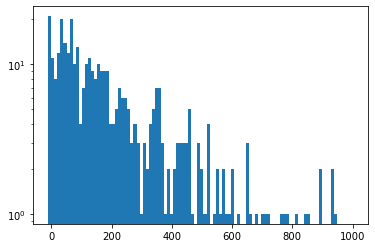

In [26]:
a = plt.hist(error_list, bins = 100, range = (-10,1000), log = True)

4.155143092795124
3.9173430694523383
72.67444420378496
2236.36


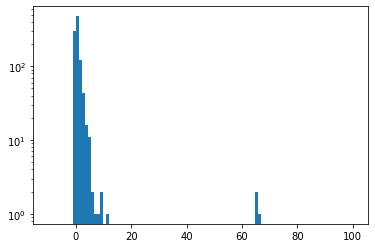

In [23]:
#plt.hist(error_list, bins = 100, log = True)
a = plt.hist(error_percent, bins = 100, range = (-10,100), log = True)
print(np.mean(np.abs(error_percent)))
print(np.mean(error_percent))
print(np.std(error_percent))
print(np.max(np.abs(error_percent)))

## Batches

In [32]:
#Summary: here we are comparing grid and reported travel time
#jupyter functions assume many variables are global like g (grid object) and peakHours (np array)
def nsample_verification(sample_start,nsamples):
    error_list = []
    error_percent = []
    for i in range(sample_start,sample_start + nsamples):
        start_pt = g.map_point_to_region(float(peakHours[i,5]),float(peakHours[i,4]))
        end_pt = g.map_point_to_region(float(peakHours[i,7]),float(peakHours[i,6]))
        grid_time = g.get_time(start_pt,end_pt)
        reported_time = float(peakHours[i,3])
#         if(reported_time > 1800):
#             continue
        error_list.append(reported_time -  grid_time)
#     print(np.mean(np.abs(error_percent)))
#     print(np.mean(error_percent))
#     print(np.std(error_percent))
#     print(np.max(np.abs(error_percent)))
    return (error_list, np.mean(error_list), np.std(error_list))

In [54]:
#log-log linear regression
slope = 0.23868463365149437 
intercept = 1.261777659720721

def nsample_verification_log_regression(sample_start,nsamples):
    error_list = []
    error_percent = []
    for i in range(sample_start,sample_start + nsamples):
        start_pt = g.map_point_to_region(float(peakHours[i,5]),float(peakHours[i,4]))
        end_pt = g.map_point_to_region(float(peakHours[i,7]),float(peakHours[i,6]))
        grid_time = g.get_time(start_pt,end_pt)
        reported_time = float(peakHours[i,3])

        grid_time = grid_time / 60
        if(grid_time  < .1):
            continue
        grid_time = np.exp(np.log(grid_time)*slope + intercept) * 60       
        if(reported_time > 1800):
            continue
            
        error_list.append(reported_time -  grid_time)
    return (error_list, np.mean(error_list), np.std(error_list))


In [55]:
np.random.seed(0)
mrp_mean_secs = []
mrp_std_secs = []
sample_ind = []
for i in range(20):
    nsamples = 1000
    start = np.random.randint(low = 1, high = len(peakHours) - nsamples)
    erros_list, mean_seconds, std_seconds = nsample_verification_log_regression(start,nsamples)
    mrp_mean_secs.append(mean_seconds)
    mrp_std_secs.append(std_seconds)
    sample_ind.append(start)

In [56]:
print(np.mean(mrp_mean_secs))
print(np.std(mrp_mean_secs))
print(np.mean(mrp_std_secs))
print(np.std(mrp_std_secs))

99.2530229211548
20.452590526995248
248.71278835725496
12.54444934369318


Journal #2 7_19_21

print(np.mean(mrp_mean_secs))
print(np.std(mrp_mean_secs))
print(np.mean(mrp_std_secs))
print(np.std(mrp_std_secs))

Original:
    -68.305403375
    47.64801015196787
    777.3492421206404
    828.4805357610593

Remove reported times over 30 minutes:
    -105.88601923255867
    18.183563418857975
    347.6933307854862
    17.073839379764028
    
Regression:
    141.29845800855966
    47.2311297535124
    723.2293615600521
    846.9660056437793
    
Regression w/ trimmed data (over 30 min reported time):
    99.2530229211548
    20.452590526995248
    248.71278835725496
    12.54444934369318

#maybe I need a new regression on the new data set

    


JOURNAL #1

print(np.mean(mrp_mean_secs))
print(np.std(mrp_mean_secs))
print(np.mean(mrp_std_secs))
print(np.std(mrp_std_secs))

Original:
    -169.3827825
    43.433218727562995
    865.5796475482963
    909.0123950506306
Global:
    -23.382782499999998
    43.433218727562995
    865.5796475482963
    909.0123950506306
Bins:   
    -10.426597950259458
    37.34551863813396
    734.4298909383522
    965.1893347678395
log-log regression:
<!--     0.9459934054929257 #was this in minutes??
    0.5485883217552645
    10.312311628294795
    15.522823813900242 -->
    41.841701892569695
    17.676115368057115
    212.17378569138637
    19.27757626181333




In [14]:
#MRP? https://uweb.engr.arizona.edu/~guzinb/webpage_before_June_30_2008/files/bm_compstat.pdf